# Hybrid Reinforcement Learning + Forecast-Based Battery Scheduling  
Team name: Solaris Nexus: where solar energy meets global sustainability

### Using Real Solar Power Generation Data (Plant 1 – Kaggle Dataset)

This notebook demonstrates an end-to-end implementation of a **hybrid reinforcement learning (RL) controller (and a forecasting module)** for solar battery management using real-world data from the *Solar Power Generation Data* dataset available on Kaggle.  
The dataset contains 34 days of solar generation and weather sensor readings collected from two power plants in India.  
We use only **Plant 1** for consistency and clarity.

The workflow includes:  
1. **Data preprocessing and cleaning**  
2. **Linear regression–based short-term PV forecasting**  
3. **Reinforcement learning (Q-learning) battery control**  
4. **Hybrid integration of forecast signals with RL policy**  
5. **Performance comparison with a rule-based baseline**  
6. **Professional visualization and analysis**

**Dataset Source:** [Solar Power Generation Data – Kaggle](https://www.kaggle.com/datasets/anikannal/solar-power-generation-data)

This setup enables energy-efficient battery scheduling that reduces grid import and optimizes overall solar utilization.  
The project was developed as part of the **NYAS Junior Academy Challenge** on sustainable energy systems.

In [ ]:
import pandas as pd
import numpy as np

gen_df = pd.read_csv("Plant_1_Generation_Data.csv")
weather_df = pd.read_csv("Plant_1_Weather_Sensor_Data.csv")

# Convert timestamps
gen_df["DATE_TIME"] = pd.to_datetime(gen_df["DATE_TIME"], format="%d-%m-%Y %H:%M")
weather_df["DATE_TIME"] = pd.to_datetime(weather_df["DATE_TIME"], format="%Y-%m-%d %H:%M:%S")

# Aggregate inverter power
gen_agg = gen_df.groupby("DATE_TIME")[["DC_POWER", "AC_POWER", "DAILY_YIELD", "TOTAL_YIELD"]].sum().reset_index()

# Merge with weather data
merged = pd.merge_asof(
    gen_agg.sort_values("DATE_TIME"),
    weather_df.sort_values("DATE_TIME")[["DATE_TIME", "IRRADIATION", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE"]],
    on="DATE_TIME"
)

merged = merged.dropna().reset_index(drop=True)
merged["hour"] = merged["DATE_TIME"].dt.hour
merged["day_of_year"] = merged["DATE_TIME"].dt.dayofyear

# Normalize PV power to 5kW system
PV_RATED_KW = merged["DC_POWER"].max()
merged["pv_kw"] = (merged["DC_POWER"] / PV_RATED_KW) * 5.0

# Synthetic residential load
np.random.seed(42)
hours = merged["hour"]
base = 0.6
morning_peak = np.exp(-0.5 * ((hours - 8)/2.0)**2)
evening_peak = np.exp(-0.5 * ((hours - 19)/2.0)**2)
load_profile = base + 1.0*morning_peak + 1.2*evening_peak
merged["load_kw"] = 2.0*load_profile + 0.2*np.random.randn(len(merged))
merged["load_kw"] = merged["load_kw"].clip(lower=0.3)

# Final dataframe
control_df = merged[["DATE_TIME","pv_kw","load_kw","IRRADIATION","AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","hour","day_of_year"]].copy()
control_df = control_df.set_index("DATE_TIME")

print(control_df.shape)
display(control_df.head(10))

(3158, 7)


,pv_kw,load_kw,IRRADIATION,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,hour,day_of_year
DATE_TIME,,,,,,,
2020-05-15 00:00:00,0.0,1.300014,0.0,25.184316,22.857507,0,136
2020-05-15 00:15:00,0.0,1.173018,0.0,25.084589,22.761668,0,136
2020-05-15 00:30:00,0.0,1.330209,0.0,24.935753,22.592306,0,136
2020-05-15 00:45:00,0.0,1.505277,0.0,24.846130,22.360852,0,136
2020-05-15 01:00:00,0.0,1.157544,0.0,24.621525,22.165423,1,136
2020-05-15 01:15:00,0.0,1.157548,0.0,24.536092,21.968571,1,136
2020-05-15 01:30:00,0.0,1.520218,0.0,24.638674,22.352926,1,136
2020-05-15 01:45:00,0.0,1.357862,0.0,24.873022,23.160919,1,136
2020-05-15 02:00:00,0.0,1.128323,0.0,24.936930,23.026113,2,136


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

data = control_df.copy()
X = data[["IRRADIATION","AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","hour","day_of_year"]]
y = data["pv_kw"]

# 70/30 chronological split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.3)

# Train model
lr = LinearRegression().fit(X_train, y_train)

# Predict and evaluate
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
mean_pv = y.max()

print(f"Train MAE = {mae_train:.2f} kW")
print(f"Test MAE  = {mae_test:.2f} kW")
print(f"Test R²   = {r2:.3f}")
print(f"Mean Abs Error = {(mae_test/mean_pv*100):.2f}% of rated PV capacity")

Train MAE = 0.07 kW
Test MAE  = 0.08 kW
Test R²   = 0.992
Mean Abs Error = 1.55% of rated PV capacity


In [ ]:
DT_HOURS = 0.25
BATTERY_CAP_KWH = 10.0
MAX_CHARGE_KW = 3.0
MAX_DISCHARGE_KW = -3.0
ETA_CHARGE = 0.95
ETA_DISCHARGE = 0.95

split_idx = int(len(control_df)*0.7)
train_ctrl = control_df.iloc[:split_idx]
test_ctrl = control_df.iloc[split_idx:]

def step_environment(soc, action_kw, pv_kw, load_kw):
    action_kw = np.clip(action_kw, MAX_DISCHARGE_KW, MAX_CHARGE_KW)
    delta = (action_kw*ETA_CHARGE*DT_HOURS)/BATTERY_CAP_KWH if action_kw>=0 else (action_kw/ETA_DISCHARGE*DT_HOURS)/BATTERY_CAP_KWH
    soc_next = np.clip(soc + delta, 0, 1)
    p_batt = action_kw
    p_grid = load_kw - pv_kw + p_batt
    p_import = max(p_grid, 0)
    p_export = max(-p_grid, 0)
    reward = -(2*p_import - 0.5*p_export + 0.05*abs(p_batt) + 0.2*abs(soc - 0.5))
    return soc_next, p_batt, p_import, reward

def rule_policy(soc, pv, load, hour):
    if pv > load + 0.3 and soc < 0.8 and 9 <= hour <= 15:
        return MAX_CHARGE_KW
    if load > pv + 0.3 and soc > 0.2 and (hour >= 18 or hour <= 7):
        return MAX_DISCHARGE_KW/2
    return 0.0

In [ ]:
forecast_cache = []
for i in range(len(train_ctrl)):
    pv_preds = []
    for j in range(4):
        if i + j < len(train_ctrl):
            Xf = train_ctrl.iloc[i+j][["IRRADIATION",
                                       "AMBIENT_TEMPERATURE",
                                       "MODULE_TEMPERATURE",
                                       "hour",
                                       "day_of_year"]]
            pv_preds.append(lr.predict(pd.DataFrame([Xf]))[0])
    pv_pred_kw = np.clip(np.mean(pv_preds), 0, 5.0)
    forecast_cache.append(pv_pred_kw)

print("Forecast cache length:", len(forecast_cache))

Forecast cache length: 2210


In [19]:
from collections import defaultdict

ACTIONS = np.array([MAX_DISCHARGE_KW, MAX_DISCHARGE_KW/2, 0, MAX_CHARGE_KW/2, MAX_CHARGE_KW])
ALPHA = 0.05
GAMMA = 0.98
EPS_END = 0.01
NUM_EPISODES = 200  # balanced speed + performance

def hour_group(hour):
    if 6 <= hour < 10: return 1
    elif 10 <= hour < 16: return 2
    elif 16 <= hour < 21: return 3
    else: return 0

def net_condition(pv_kw, load_kw, margin=0.3):
    if pv_kw > load_kw + margin: return 0
    elif load_kw > pv_kw + margin: return 1
    else: return 2

def encode_state_hybrid(soc, pv_kw, load_kw, hour, pv_pred_kw):
    soc_bin = int(np.floor(soc * 10))
    forecast_bin = int(np.clip(np.floor((pv_pred_kw / 5.0) * 4), 0, 3))
    return (soc_bin, hour_group(hour), net_condition(pv_kw, load_kw), forecast_bin)

# --- Initialize Q-table
Qh = defaultdict(lambda: np.zeros(len(ACTIONS)))

# --- Training loop with rolling forecast updates
for ep in range(NUM_EPISODES):
    eps = EPS_END + (1 - EPS_END) * (NUM_EPISODES - 1 - ep) / (NUM_EPISODES - 1)
    soc, total_r = 0.5, 0.0
    pv_pred_kw, pv_pred_kw2 = 0, 0  # initialize forecasts

    for i in range(len(train_ctrl) - 1):
        r0, r1 = train_ctrl.iloc[i], train_ctrl.iloc[i + 1]

        # Update forecast every 4 steps (~1 hour)
        if i % 4 == 0 or i == 0:
            irr_preds = []
            for j in range(4):
                if i + j < len(train_ctrl):
                    Xf = train_ctrl.iloc[i + j][["IRRADIATION", "AMBIENT_TEMPERATURE",
                                                 "MODULE_TEMPERATURE", "hour", "day_of_year"]]
                    irr_preds.append(lr.predict(pd.DataFrame([Xf]))[0])
            pv_pred_kw = np.clip(np.mean(irr_preds), 0, 5.0)
        else:
            pv_pred_kw = pv_pred_kw  # reuse previous forecast

        # Next-step forecast update (rolling)
        if (i + 1) % 4 == 0:
            irr_preds2 = []
            for j in range(4):
                if i + 1 + j < len(train_ctrl):
                    Xf = train_ctrl.iloc[i + 1 + j][["IRRADIATION", "AMBIENT_TEMPERATURE",
                                                     "MODULE_TEMPERATURE", "hour", "day_of_year"]]
                    irr_preds2.append(lr.predict(pd.DataFrame([Xf]))[0])
            pv_pred_kw2 = np.clip(np.mean(irr_preds2), 0, 5.0)
        else:
            pv_pred_kw2 = pv_pred_kw2 if 'pv_pred_kw2' in locals() else pv_pred_kw

        # Encode state and act
        s = encode_state_hybrid(soc, r0.pv_kw, r0.load_kw, r0.hour, pv_pred_kw)
        a_i = np.random.randint(len(ACTIONS)) if np.random.rand() < eps else int(np.argmax(Qh[s]))

        # Environment step
        soc_n, _, _, r = step_environment(soc, ACTIONS[a_i], r0.pv_kw, r0.load_kw)

        # Encode next state and update Q
        s2 = encode_state_hybrid(soc_n, r1.pv_kw, r1.load_kw, r1.hour, pv_pred_kw2)
        Qh[s][a_i] += ALPHA * (r + GAMMA * np.max(Qh[s2]) - Qh[s][a_i])

        # Advance state
        soc, total_r = soc_n, total_r + r

    if (ep + 1) % 25 == 0:
        print(f"[Hybrid] Ep {ep + 1}/{NUM_EPISODES}, reward {total_r:.1f}")

print("Hybrid RL + Rolling Forecast training done")

[Hybrid] Ep 25/200, reward -5891.4
[Hybrid] Ep 50/200, reward -5152.4
[Hybrid] Ep 75/200, reward -3959.7
[Hybrid] Ep 100/200, reward -3072.5
[Hybrid] Ep 125/200, reward -1776.0
[Hybrid] Ep 150/200, reward -590.2
[Hybrid] Ep 175/200, reward 359.7
[Hybrid] Ep 200/200, reward 1461.8
Hybrid RL + Rolling Forecast training done


In [20]:
def simulate(df, policy_fn, hybrid=False):
    soc, records = 0.5, []
    for i, (t, row) in enumerate(df.iterrows()):
        pv, load, hour = row.pv_kw, row.load_kw, row.hour
        pv_pred = None

        if hybrid:
            pv_preds = []
            for j in range(4):
                if i+j < len(df):
                    Xf = df.iloc[i+j][["IRRADIATION","AMBIENT_TEMPERATURE","MODULE_TEMPERATURE","hour","day_of_year"]]
                    pv_preds.append(lr.predict(pd.DataFrame([Xf]))[0])
            pv_pred = np.clip(np.mean(pv_preds), 0, 5.0)

        act = policy_fn(soc, pv, load, hour, pv_pred)
        soc_n, p_b, p_imp, _ = step_environment(soc, act, pv, load)
        records.append({"soc": soc, "p_batt": p_b, "p_imp": p_imp})
        soc = soc_n

    df_out = pd.DataFrame(records)
    tot_imp = df_out["p_imp"].sum() * DT_HOURS
    thr = df_out["p_batt"].abs().sum() * DT_HOURS
    eq_cyc = thr / (2 * BATTERY_CAP_KWH)
    return {"grid_import_kwh": tot_imp, "eq_full_cycles": eq_cyc}


def rule_based_policy(soc, pv, load, hour, pred=None):
    return rule_policy(soc, pv, load, hour)

def hybrid_policy(soc, pv, load, hour, pred):
    s = encode_state_hybrid(soc, pv, load, hour, pred)
    return ACTIONS[int(np.argmax(Qh[s]))]


m_base = simulate(test_ctrl, rule_based_policy)
m_hyb  = simulate(test_ctrl, hybrid_policy, hybrid=True)

print("Performance Summary")
print("Rule-based :", m_base)
print("Hybrid     :", m_hyb)

Performance Summary
Rule-based : {'grid_import_kwh': np.float64(300.5532419894164), 'eq_full_cycles': np.float64(6.58125)}
Hybrid     : {'grid_import_kwh': np.float64(11.126099309384651), 'eq_full_cycles': np.float64(35.55)}


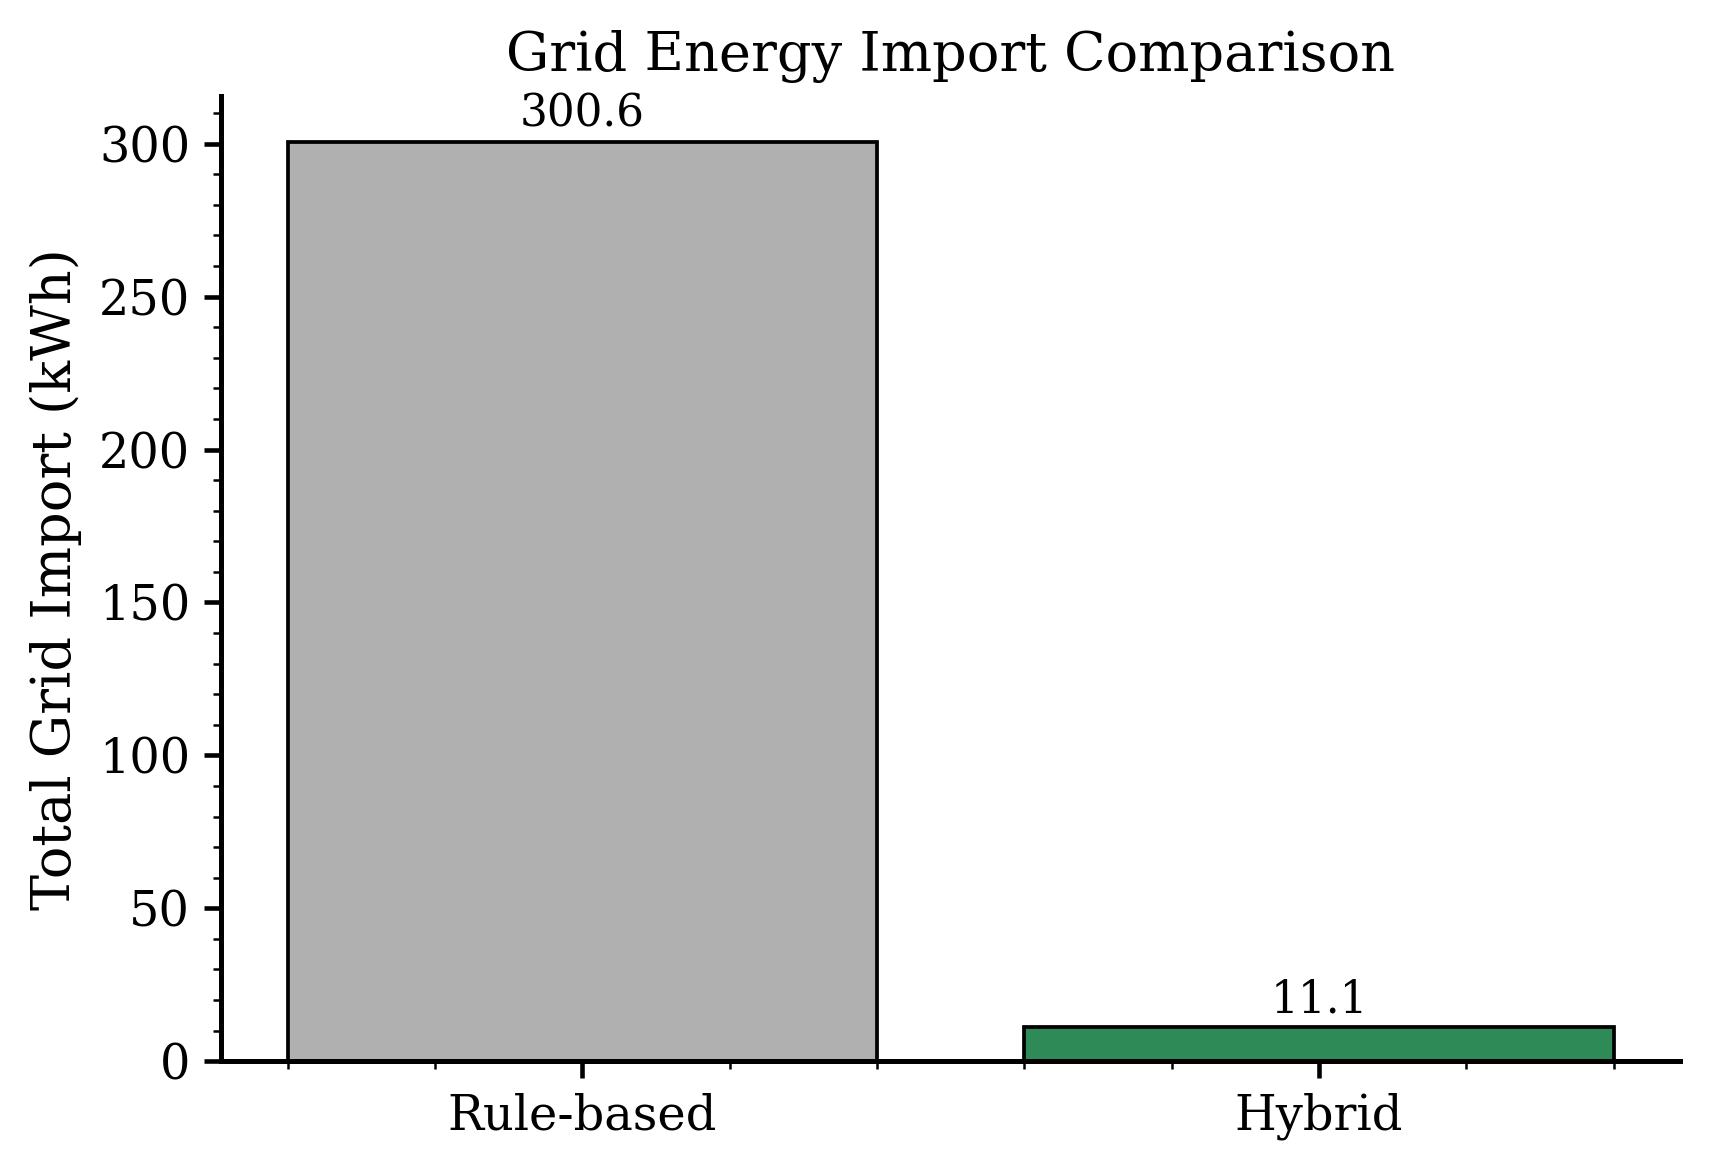

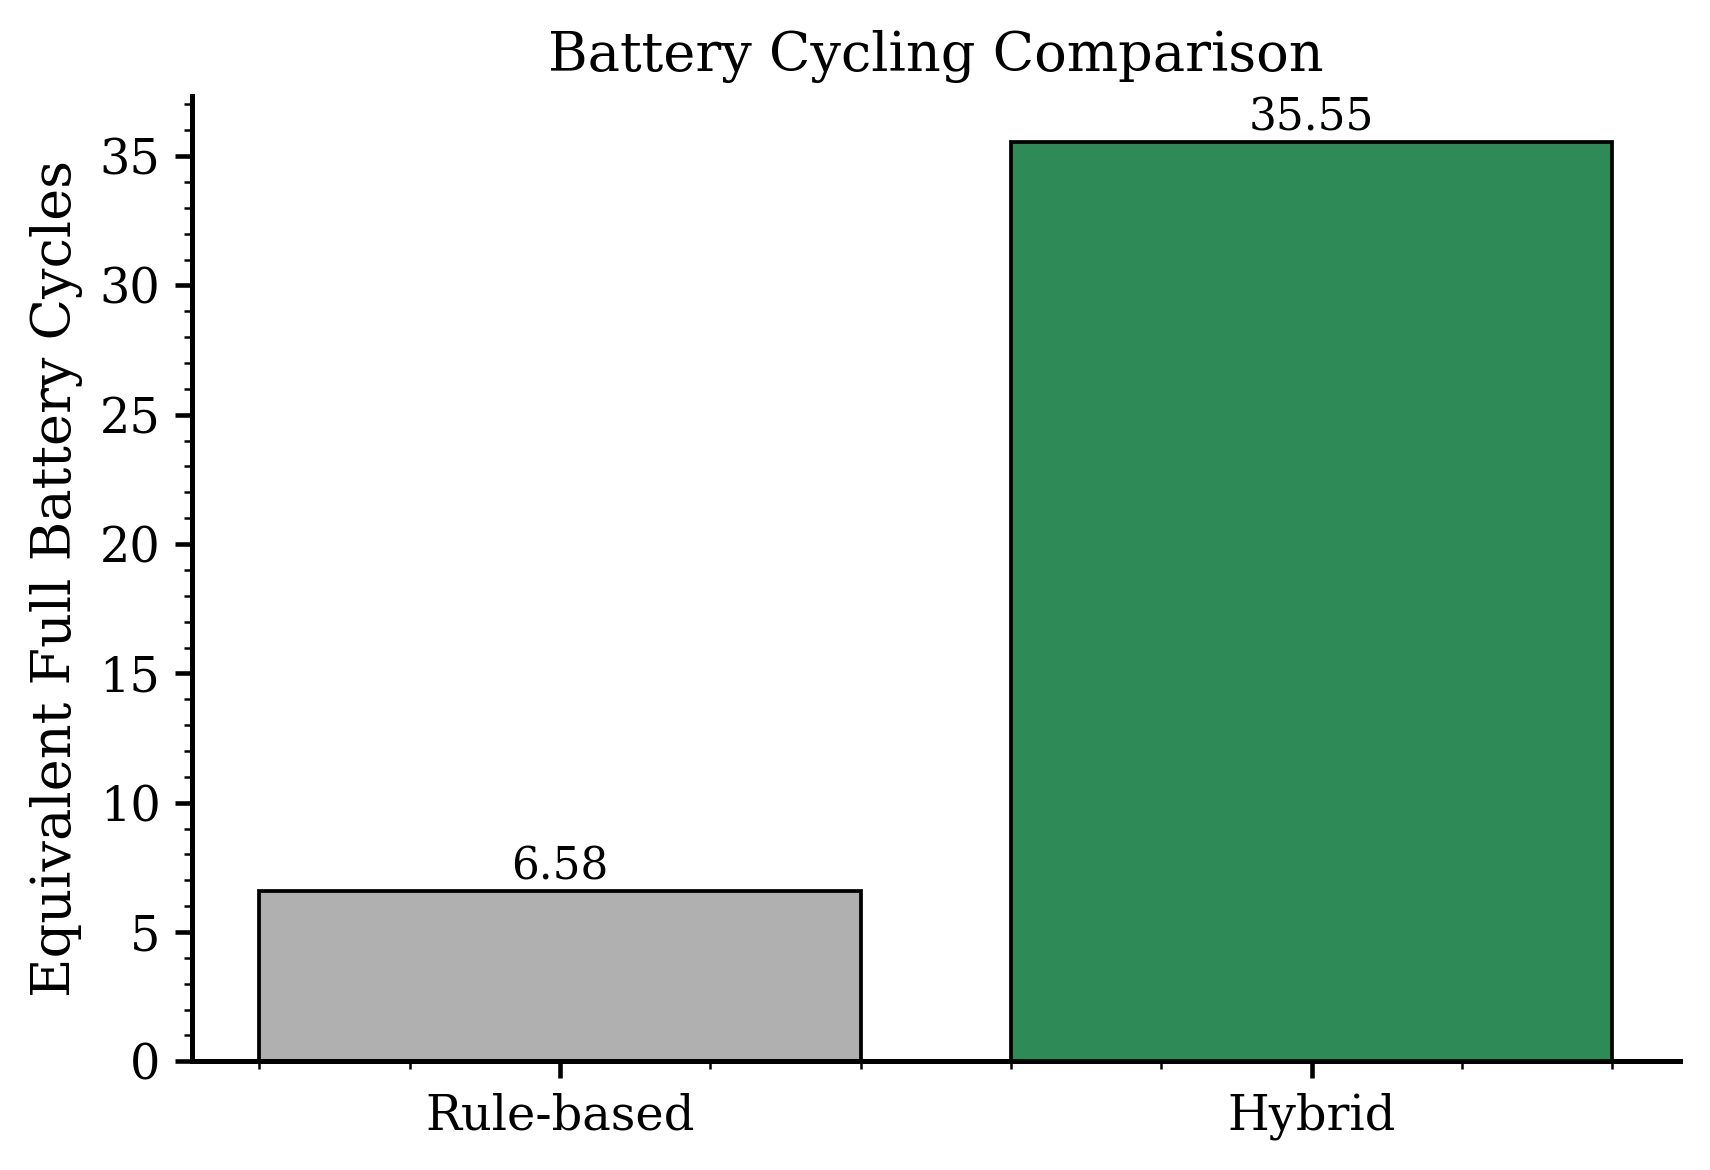

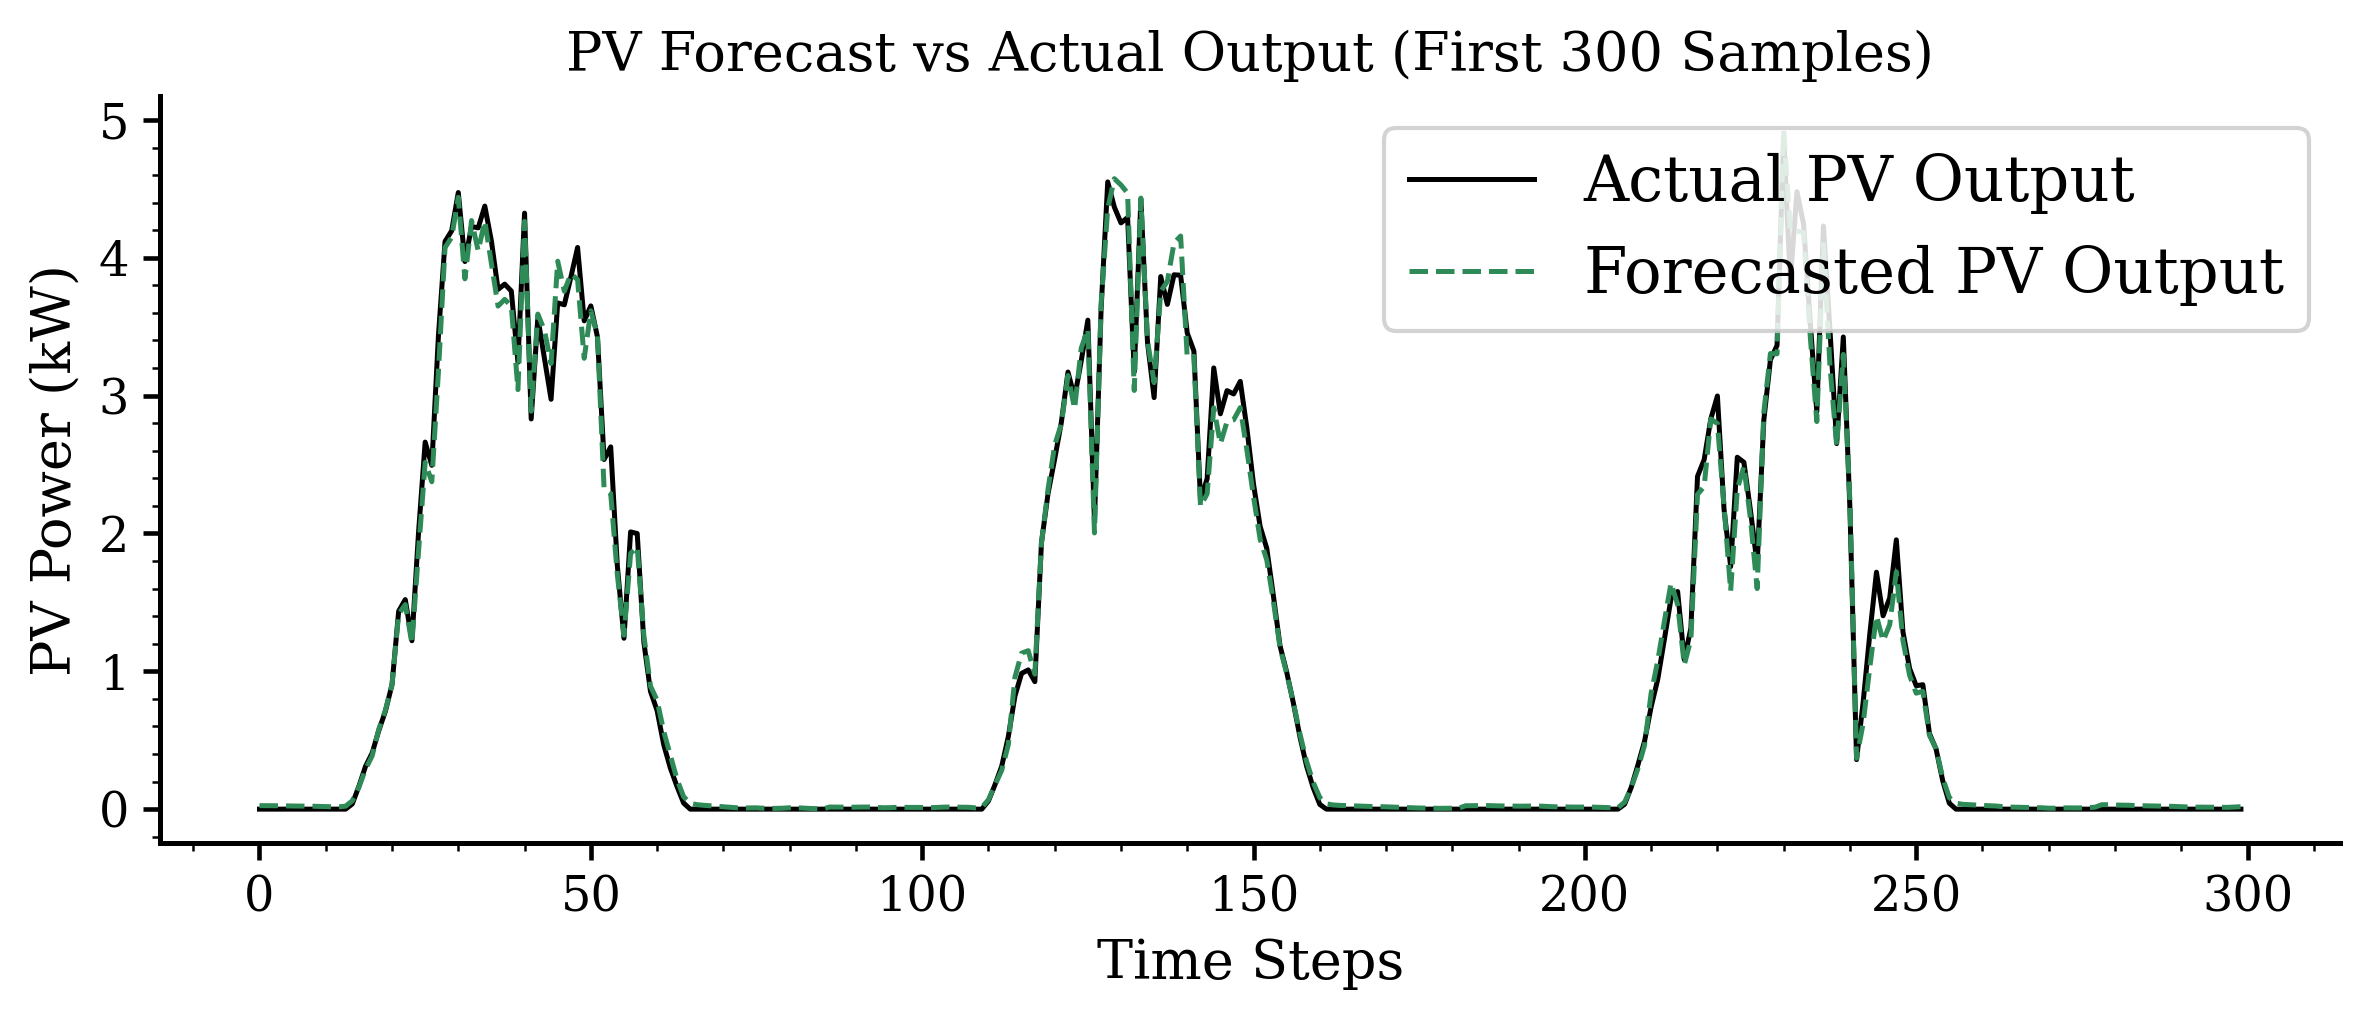

In [27]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

mpl.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "axes.linewidth": 1.2,
    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "xtick.labelsize": 11.5,
    "ytick.labelsize": 11.5,
    "legend.fontsize": 11,
    "figure.dpi": 300,
})

def style_axes(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.minorticks_on()
    ax.tick_params(direction="out", length=4, width=1.1)

labels = ["Rule-based", "Hybrid"]
colors = ["#B0B0B0", "#2E8B57"]

fig, ax = plt.subplots(figsize=(5.8,4))
vals = [m_base["grid_import_kwh"], m_hyb["grid_import_kwh"]]
bars = ax.bar(labels, vals, color=colors, edgecolor="black", linewidth=0.9)
ax.set_ylabel("Total Grid Import (kWh)")
ax.set_title("Grid Energy Import Comparison")
style_axes(ax)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2, h+2, f"{h:.1f}", ha="center", va="bottom", fontsize=10.5)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(5.8,4))
vals = [m_base["eq_full_cycles"], m_hyb["eq_full_cycles"]]
bars = ax.bar(labels, vals, color=colors, edgecolor="black", linewidth=0.9)
ax.set_ylabel("Equivalent Full Battery Cycles")
ax.set_title("Battery Cycling Comparison")
style_axes(ax)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2, h+0.1, f"{h:.2f}", ha="center", va="bottom", fontsize=10.5)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8,3.5))
ax.plot(y_test.values[:300], label="Actual PV Output", color="black", lw=1.2)
ax.plot(y_pred_test[:300], label="Forecasted PV Output", color="#2E8B57", lw=1.2, ls="--")
ax.set_xlabel("Time Steps")
ax.set_ylabel("PV Power (kW)")
ax.set_title("PV Forecast vs Actual Output (First 300 Samples)")
ax.legend(frameon=True, loc="best", facecolor="white", framealpha=0.85, fontsize=15)
style_axes(ax)
plt.tight_layout()
plt.show()